In [1]:
from __future__ import division, absolute_import, print_function

import os
import argparse
import warnings
import numpy as np
import cv2
from tqdm import tqdm
from keras.models import load_model
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

from detect.util import (get_data, get_mc_predictions, normalize)

Using TensorFlow backend.


In [2]:
def crop_resize(X,batch_size):
    n_batches = int(np.ceil(X.shape[0] / float(batch_size)))
    ls=[]
    for i in range(n_batches):
        X_batch = X[i * batch_size:(i + 1) * batch_size]
        new_X = np.transpose(X_batch.squeeze(axis=-1),(1,2,0))
        #X_center = cv2.resize(new_X[4:24,4:24,:],dsize=(28,28),interpolation=cv2.INTER_CUBIC)
        X_center = cv2.resize(new_X[1:-1,1:-1,:],dsize=(28,28),interpolation=cv2.INTER_CUBIC)
        X_left_top = cv2.resize(new_X[:27,:27,:],dsize=(28,28),interpolation=cv2.INTER_CUBIC)
        X_left_bot = cv2.resize(new_X[1:,:27,:],dsize=(28,28),interpolation=cv2.INTER_CUBIC)
        X_right_top = cv2.resize(new_X[:27,1:,:],dsize=(28,28),interpolation=cv2.INTER_CUBIC)
        X_right_bot = cv2.resize(new_X[1:,1:,:],dsize=(28,28),interpolation=cv2.INTER_CUBIC)
        X_proc = np.asarray([X_center,X_left_top,X_left_bot,X_right_top,X_right_bot])
        X_proc = np.transpose(X_proc,(0,3,1,2))
        ls.append(X_proc)
    X_proc=np.concatenate(ls,axis=1)
    return np.expand_dims(X_proc,axis=-1)

def preprocess_infer(X, preds, model, batch_size, C):
    X_proc = crop_resize(X,batch_size)
    label = np.zeros(preds.shape[0])
    ct = np.zeros(preds.shape[0])
    for i in range(5):
        x = X_proc[i]
        new_preds = model.predict_classes(x, verbose=0, batch_size=batch_size)
        same_or_not = new_preds==preds
        ct += same_or_not
    label[np.where(ct>=C)[0]] = 1

    return label

def detect_clean_adv(X, preds, uncert, model, C, H, L, batch_size):
    label = -1 * np.ones(preds.shape[0])
    #print(label.shape[0])
    label[np.where(uncert>H)[0]] = 0
    #middle_idx = np.where(label == -1)[0]
    #print(middle_idx.shape[0])
    label[np.where(uncert<L)[0]] = 1
    middle_idx = np.where(label == -1)[0]
    #print(middle_idx.shape[0])
    if middle_idx.shape[0] != 0:
        label[middle_idx] = preprocess_infer(X[middle_idx], preds[middle_idx], model, batch_size, C)
    return label

def detect_clean_adv_v2(X, preds, uncert, model, C, H, L, batch_size):
    label = -1 * np.ones(preds.shape[0])
    #print(label.shape[0])
    label[np.where(uncert>H)[0]] = 0
    #middle_idx = np.where(label == -1)[0]
    #print(middle_idx.shape[0])
    label[np.where(uncert<=H)[0]] = 1
    #middle_idx = np.where(label == -1)[0]
    #print(middle_idx.shape[0])
    #if middle_idx.shape[0] != 0:
    #    label[middle_idx] = preprocess_infer(X[middle_idx], preds[middle_idx], model, batch_size, C)
    return label

In [23]:
import keras.backend as K
def get_mc_predictions(model, X, nb_iter=50, batch_size=256):
    """
    TODO
    :param model:
    :param X:
    :param nb_iter:
    :param batch_size:
    :return:
    """
    output_dim = model.layers[-1].output.shape[-1].value
    get_output = K.function(
        [model.layers[0].input, K.learning_phase()],
        [model.layers[-1].output]
    )

    def predict():
        n_batches = int(np.ceil(X.shape[0] / float(batch_size)))
        output = np.zeros(shape=(len(X), output_dim))
        for i in range(n_batches):
            output[i * batch_size:(i + 1) * batch_size] = \
                get_output([X[i * batch_size:(i + 1) * batch_size], 1])[0]
        return output

    preds_mc = []
    for i in range(nb_iter):
        preds_mc.append(predict())

    return np.asarray(preds_mc)

attack='fgsm'
for sd in range(0,10):
    print("seed: "+str(sd))
    with_norm=False
    batch_size=256
    #main(attack,with_norm,batch_size)
    np.random.seed(sd)
    idx0=np.random.choice(10000,5000)
    dataset='mnist'
    text_file = open("../stats/"+attack+"_stats.txt", "w")
    assert attack in ['fgsm', 'bim', 'bim-a', 'bim-b', 'jsma'], \
        "Attack parameter must be either 'fgsm', 'bim', bim-a', 'bim-b', 'jsma'"
    assert os.path.isfile('../data/model_%s.h5' % dataset), \
        'model file not found... must first train model using train_model.py.'
    assert os.path.isfile('../data/Adv_%s_%s.npy' % (dataset, attack)), \
        'adversarial sample file not found... must first craft adversarial ' \
        'samples using craft_adv_samples.py'
    print('Loading the data and model...')
    # Load the model
    model = load_model('../data/model_%s.h5' % dataset)
    # Load the dataset
    X_train, Y_train, X_test, Y_test = get_data()
    # Check attack type, select adversarial samples accordingly
    print('Loading adversarial samples...')
    X_test_adv = np.load('../data/Adv_%s_%s.npy' % (dataset, attack))



    ################################################ Table 1 ###########################################
    #Get half data from clean and adversarial images respectively and combine them
    X_test, Y_test, X_test_adv = X_test[idx0], Y_test[idx0], X_test_adv[idx0]
    X_test_all_un = np.concatenate((X_test, X_test_adv),axis=0)
    Y_test_all_un = np.concatenate((Y_test, Y_test),axis=0)
    # Check model accuracies on each sample type and then on combined undefended dataset
    for s_type, dt in zip(['normal', 'adversarial'], [X_test, X_test_adv]):
        _, acc = model.evaluate(dt, Y_test, batch_size=batch_size, verbose=0)
        print("Model accuracy on the %s test set: %0.2f%%" % (s_type, 100 * acc))
    _, acc = model.evaluate(X_test_all_un, Y_test_all_un, batch_size=batch_size, verbose=0)
    print("Model accuracy on the combined undefended test set: %0.2f%%" % (100 * acc))
    
    
    ################################################ Table 2 ###########################################
    # Refine the normal and adversarial sets to only include samples,
    # for which the original version was correctly classified by the model.
    # Then, create detector label for clean as "1" and for adversarial as "0"
    preds_test = model.predict_classes(X_test, verbose=0, batch_size=batch_size)
    inds_correct = np.where(preds_test == Y_test.argmax(axis=1))[0]
    X_test = X_test[inds_correct]
    X_test_adv = X_test_adv[inds_correct]
    Y_test = Y_test[inds_correct]
    label_clean=np.ones(Y_test.shape[0])
    label_adv=np.zeros(Y_test.shape[0])

    # Combine the filtered dataset and detector label
    X_test_all_filtered = np.concatenate((X_test, X_test_adv),axis=0)
    Y_test_all_filtered = np.concatenate((Y_test, Y_test),axis=0)
    label_filtered = np.concatenate((label_clean, label_adv),axis=0)

    # Get Prediction + Bayesian uncertainty scores
    print('Getting Monte Carlo dropout variance predictions...')
    #pred_normal = get_mc_predictions(model, X_test, batch_size=batch_size)
    #pred_adv = get_mc_predictions(model, X_test_adv, batch_size=batch_size)
    pred_all_filtered = get_mc_predictions(model, X_test_all_filtered, batch_size=batch_size)
    #uncerts_normal = pred_normal.var(axis=0).mean(axis=1)
    #uncerts_adv = pred_adv.var(axis=0).mean(axis=1)
    uncerts_all = pred_all_filtered.var(axis=0).mean(axis=1)
    if with_norm:
        ## Z-score the uncertainty
        uncerts_all = normalize(uncerts_all)
    #uncerts_all = np.concatenate((uncerts_normal, uncerts_adv),axis=0)
    #class_normal = pred_normal.mean(axis=0).argmax(axis=1)
    #class_adv = pred_adv.mean(axis=0).argmax(axis=1)
    #preds_test_all_filtered = np.concatenate((class_normal, class_adv),axis=0)
    preds_test_all_filtered = pred_all_filtered.mean(axis=0).argmax(axis=1)
    
    # Detector Parameters to be fine-tuned in experiments
    params = {
        'fgsm': {'H': 0.002,  'L': 0.000003, 'C': 5},
        'bim':  {'H': 0.0022, 'L': 0.0012,   'C': 5},
        'jsma': {'H': 0.01,   'L': 0.003,    'C': 5}
    }
    start_H, start_L, start_C = params[attack]["H"], params[attack]["L"], params[attack]["C"]
    H_range, L_range, C_range = 0, 0, 1
    H_step, L_step, C_step = 1e-4, 5e-6, 1

    threshold_ls=[]
    estimator = DecisionTreeClassifier(criterion='entropy',max_leaf_nodes=3, splitter='best',random_state=None)
    X = np.expand_dims(uncerts_all,axis=-1)
    Y = label_filtered
    estimator.fit(X, Y)
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right
    threshold = estimator.tree_.threshold
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True
    for i in range(n_nodes):
        if not is_leaves[i]:
            threshold_ls.append(threshold[i])
    start_H_d=max(threshold_ls)
    start_L_d=min(threshold_ls)

    #Detection
    for C in range(start_C, min(start_C+C_range,5)+C_step, C_step):
        for sad in range(2):
            H=[start_H_d,start_H][sad]
            L=[start_L_d,start_L][sad]
            label_pred=detect_clean_adv(X_test_all_filtered, preds_test_all_filtered, uncerts_all, model, C, H, L, batch_size)
            #Detection Evaluation
            CM=confusion_matrix(label_filtered, label_pred)
            TN = CM[0][0]
            FN = CM[1][0]
            TP = CM[1][1]
            FP = CM[0][1]
            ACC_DETECT = (TP+TN)/(TP+TN+FP+FN)
            res_detect = "Seed: " + str(sd) + ", C: " + str(C) + ", H: " + str(H)+ ", L: " + str(L) \
                            + "\nDetection Acc: " + str(ACC_DETECT*100)[:4] \
                            + "%, False Negative: " + str(FN) + ", False Positive: " + str(FP) \
                            + ", True Negative: " + str(TN) + ", True Positive: " + str(TP)+"."
            print(res_detect)
            text_file.write(res_detect+"\n")

            ################################################ Table 3 ###########################################
            #Only get images reported as clean
            idx_clean_reported=np.where(label_pred)[0]
            X_test_all_def = X_test_all_filtered[idx_clean_reported]
            Y_test_all_def = Y_test_all_filtered[idx_clean_reported]
            label_def = label_filtered[idx_clean_reported]
            num_all=label_def.shape[0]

            # Reclassification
            print('Computing final model predictions...')
            preds_test_all_def = model.predict_classes(X_test_all_def, verbose=0, batch_size=batch_size)
            inds_correct_def = np.where(preds_test_all_def == Y_test_all_def.argmax(axis=1))[0]
            inds_incorrect_def = np.where(preds_test_all_def != Y_test_all_def.argmax(axis=1))[0]

            # Reclassification Evaluation 
            num_clean_correct = np.argwhere(label_def[inds_correct_def] == 1).shape[0]
            num_clean_incorrect = np.argwhere(label_def[inds_incorrect_def] == 1).shape[0]
            num_adv_correct = np.argwhere(label_def[inds_correct_def] == 0).shape[0]
            num_adv_incorrect = np.argwhere(label_def[inds_incorrect_def] == 0).shape[0]
            clean_correct_acc = num_clean_correct/num_all
            clean_incorrect_acc = num_clean_incorrect/num_all
            adv_correct_acc = num_adv_correct/num_all
            adv_incorrect_acc = num_adv_incorrect/num_all
            total_acc = clean_correct_acc + adv_correct_acc
            res_reclf = "Reclassification Acc: " + str(total_acc*100)[:4] \
            + "%, Clean Correct Acc: " + str(clean_correct_acc*100)[:4] \
            + "%, Clean Incorrect Acc: " + str(clean_incorrect_acc*100)[:4] \
            + "%, Adv Correct Acc: " + str(adv_correct_acc*100)[:4] \
            + "%, Adv Incorrect Acc: " + str(adv_incorrect_acc*100)[:4] + "%."
            print(res_reclf)
            text_file.write(res_reclf+"\n")


    text_file.close()


seed: 0
Loading the data and model...
(60000, 28, 28, 1)
(60000, 10)
(10000, 28, 28, 1)
(10000, 10)
Loading adversarial samples...
Model accuracy on the normal test set: 99.02%
Model accuracy on the adversarial test set: 17.44%
Model accuracy on the combined undefended test set: 58.23%
Getting Monte Carlo dropout variance predictions...
Seed: 0, C: 5, H: 0.0007512824086006731, L: 2.7283624149276875e-05
Detection Acc: 92.2%, False Negative: 539, False Positive: 231, True Negative: 4720, True Positive: 4412.
Computing final model predictions...
Reclassification Acc: 95.3%, Clean Correct Acc: 95.0%, Clean Incorrect Acc: 0.0%, Adv Correct Acc: 0.30%, Adv Incorrect Acc: 4.67%.
Seed: 0, C: 5, H: 0.002, L: 3e-06
Detection Acc: 90.7%, False Negative: 379, False Positive: 532, True Negative: 4419, True Positive: 4572.
Computing final model predictions...
Reclassification Acc: 91.2%, Clean Correct Acc: 89.5%, Clean Incorrect Acc: 0.0%, Adv Correct Acc: 1.64%, Adv Incorrect Acc: 8.77%.
seed: 1
Lo

In [17]:
H=0.008
L=start_L
label_pred=detect_clean_adv(X_test_all_filtered, preds_test_all_filtered, uncerts_all, model, C, H, L, batch_size)
#Detection Evaluation
CM=confusion_matrix(label_filtered, label_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
ACC_DETECT = (TP+TN)/(TP+TN+FP+FN)
res_detect = "Seed: " + str(sd) + ", C: " + str(C) + ", H: " + str(H)+ ", L: " + str(L) \
                + "\nDetection Acc: " + str(ACC_DETECT*100)[:4] \
                + "%, False Negative: " + str(FN) + ", False Positive: " + str(FP) \
                + ", True Negative: " + str(TN) + ", True Positive: " + str(TP)+"."
print(res_detect)

################################################ Table 3 ###########################################
#Only get images reported as clean
idx_clean_reported=np.where(label_pred)[0]
X_test_all_def = X_test_all_filtered[idx_clean_reported]
Y_test_all_def = Y_test_all_filtered[idx_clean_reported]
label_def = label_filtered[idx_clean_reported]
num_all=label_def.shape[0]

# Reclassification
print('Computing final model predictions...')
preds_test_all_def = model.predict_classes(X_test_all_def, verbose=0, batch_size=batch_size)
inds_correct_def = np.where(preds_test_all_def == Y_test_all_def.argmax(axis=1))[0]
inds_incorrect_def = np.where(preds_test_all_def != Y_test_all_def.argmax(axis=1))[0]

# Reclassification Evaluation 
num_clean_correct = np.argwhere(label_def[inds_correct_def] == 1).shape[0]
num_clean_incorrect = np.argwhere(label_def[inds_incorrect_def] == 1).shape[0]
num_adv_correct = np.argwhere(label_def[inds_correct_def] == 0).shape[0]
num_adv_incorrect = np.argwhere(label_def[inds_incorrect_def] == 0).shape[0]
clean_correct_acc = num_clean_correct/num_all
clean_incorrect_acc = num_clean_incorrect/num_all
adv_correct_acc = num_adv_correct/num_all
adv_incorrect_acc = num_adv_incorrect/num_all
total_acc = clean_correct_acc + adv_correct_acc
res_reclf = "Reclassification Acc: " + str(total_acc*100)[:4] \
+ "%, Clean Correct Acc: " + str(clean_correct_acc*100)[:4] \
+ "%, Clean Incorrect Acc: " + str(clean_incorrect_acc*100)[:4] \
+ "%, Adv Correct Acc: " + str(adv_correct_acc*100)[:4] \
+ "%, Adv Incorrect Acc: " + str(adv_incorrect_acc*100)[:4] + "%."
print(res_reclf)

C: 5, H: 0.008, L: 3e-06
Detection Acc: 75.7%, False Negative: 175, False Positive: 2223, True Negative: 2728, True Positive: 4776.
Computing final model predictions...
Reclassification Acc: 73.3%, Clean Correct Acc: 68.2%, Clean Incorrect Acc: 0.0%, Adv Correct Acc: 5.07%, Adv Incorrect Acc: 26.6%.


2


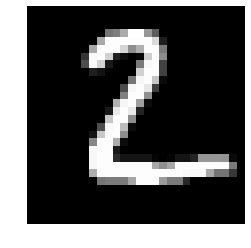

[1]


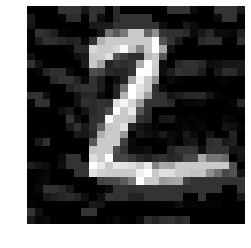

In [90]:
id=1
a=X_test[id]
print(Y_test[id].argmax(axis=-1))
a=np.squeeze(a,axis=-1)
plt.axis('off')
plt.imshow(a, cmap='gray')
plt.show()
X_test_adv = np.load('../data/Adv_%s_%s.npy' % ('mnist', 'bim'))
b=X_test_adv[id:id+1]
model = load_model('../data/model_%s.h5' % 'mnist')
print(model.predict_classes(b, verbose=0))
b=np.squeeze(b)
plt.axis('off')
plt.imshow(b, cmap='gray')
plt.show()

In [6]:
'''
print("seed: "+str(sd))
attack='fgsm'
with_norm=False
batch_size=256
#main(attack,with_norm,batch_size)
np.random.seed(sd)
idx0=np.random.choice(10000,5000)
dataset='mnist'
text_file = open("../stats/"+attack+"_stats.txt", "w")
assert attack in ['fgsm', 'bim', 'bim-a', 'bim-b', 'jsma'], \
    "Attack parameter must be either 'fgsm', 'bim', bim-a', 'bim-b', 'jsma'"
assert os.path.isfile('../data/model_%s.h5' % dataset), \
    'model file not found... must first train model using train_model.py.'
assert os.path.isfile('../data/Adv_%s_%s.npy' % (dataset, attack)), \
    'adversarial sample file not found... must first craft adversarial ' \
    'samples using craft_adv_samples.py'
print('Loading the data and model...')
# Load the model
model = load_model('../data/model_%s.h5' % dataset)
# Load the dataset
X_train, Y_train, X_test, Y_test = get_data()
# Check attack type, select adversarial samples accordingly
print('Loading adversarial samples...')
X_test_adv = np.load('../data/Adv_%s_%s.npy' % (dataset, attack))



################################################ Table 1 ###########################################
#Get half data from clean and adversarial images respectively and combine them
X_test, Y_test, X_test_adv = X_test[idx0], Y_test[idx0], X_test_adv[idx0]
X_test_all_un = np.concatenate((X_test, X_test_adv),axis=0)
Y_test_all_un = np.concatenate((Y_test, Y_test),axis=0)
# Check model accuracies on each sample type and then on combined undefended dataset
for s_type, dt in zip(['normal', 'adversarial'], [X_test, X_test_adv]):
    _, acc = model.evaluate(dt, Y_test, batch_size=batch_size, verbose=0)
    print("Model accuracy on the %s test set: %0.2f%%" % (s_type, 100 * acc))
_, acc = model.evaluate(X_test_all_un, Y_test_all_un, batch_size=batch_size, verbose=0)
print("Model accuracy on the combined undefended test set: %0.2f%%" % (100 * acc))


################################################ Table 2 ###########################################
# Refine the normal and adversarial sets to only include samples,
# for which the original version was correctly classified by the model.
# Then, create detector label for clean as "1" and for adversarial as "0"
preds_test = model.predict_classes(X_test, verbose=0, batch_size=batch_size)
inds_correct = np.where(preds_test == Y_test.argmax(axis=1))[0]
X_test = X_test[inds_correct]
X_test_adv = X_test_adv[inds_correct]
Y_test = Y_test[inds_correct]
label_clean=np.ones(Y_test.shape[0])
label_adv=np.zeros(Y_test.shape[0])

# Combine the filtered dataset and detector label
X_test_all_filtered = np.concatenate((X_test, X_test_adv),axis=0)
Y_test_all_filtered = np.concatenate((Y_test, Y_test),axis=0)
label_filtered = np.concatenate((label_clean, label_adv),axis=0)

# Get Prediction + Bayesian uncertainty scores
print('Getting Monte Carlo dropout variance predictions...')
#pred_normal = get_mc_predictions(model, X_test, batch_size=batch_size)
#pred_adv = get_mc_predictions(model, X_test_adv, batch_size=batch_size)
pred_all_filtered = get_mc_predictions(model, X_test_all_filtered, batch_size=batch_size)
#uncerts_normal = pred_normal.var(axis=0).mean(axis=1)
#uncerts_adv = pred_adv.var(axis=0).mean(axis=1)
uncerts_all = pred_all_filtered.var(axis=0).mean(axis=1)
if with_norm:
    ## Z-score the uncertainty
    uncerts_all = normalize(uncerts_all)
#uncerts_all = np.concatenate((uncerts_normal, uncerts_adv),axis=0)
#class_normal = pred_normal.mean(axis=0).argmax(axis=1)
#class_adv = pred_adv.mean(axis=0).argmax(axis=1)
#preds_test_all_filtered = np.concatenate((class_normal, class_adv),axis=0)
preds_test_all_filtered = pred_all_filtered.mean(axis=0).argmax(axis=1)

# Detector Parameters to be fine-tuned in experiments
params = {
    'fgsm': {'H': 0.0007512824086006731,  'L': 2.7283624149276875e-05, 'C': 5},
    'bim':  {'H': 0.0022, 'L': 0.0012,   'C': 5},
    'jsma': {'H': 0.01,   'L': 0.003,    'C': 4}
}
start_H, start_L, start_C = params[attack]["H"], params[attack]["L"], params[attack]["C"]
H_range, L_range, C_range = 0, 0, 2
H_step, L_step, C_step = 1e-4, 5e-6, 1

threshold_ls=[]
estimator = DecisionTreeClassifier(criterion='entropy',max_leaf_nodes=3, splitter='best',random_state=None)
X = np.expand_dims(uncerts_all,axis=-1)
Y = label_filtered
estimator.fit(X, Y)
n_nodes = estimator.tree_.node_count
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
threshold = estimator.tree_.threshold
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True
for i in range(n_nodes):
    if not is_leaves[i]:
        threshold_ls.append(threshold[i])
#start_H=max(threshold_ls)
#start_L=min(threshold_ls)

#Detection
for C in range(start_C, min(start_C+C_range,5)+C_step, C_step):
    for H in np.arange(start_H, start_H+H_range+H_step-1e-10, H_step):
        for L in np.arange(start_L, start_L+L_range+L_step-1e-10, L_step):
            label_pred=detect_clean_adv(X_test_all_filtered, preds_test_all_filtered, uncerts_all, model, C, H, L, batch_size)
            #Detection Evaluation
            CM=confusion_matrix(label_filtered, label_pred)
            TN = CM[0][0]
            FN = CM[1][0]
            TP = CM[1][1]
            FP = CM[0][1]
            ACC_DETECT = (TP+TN)/(TP+TN+FP+FN)
            res_detect = "C: " + str(C) + ", H: " + str(H)+ ", L: " + str(L) \
                            + "\nDetection Acc: " + str(ACC_DETECT*100)[:4] \
                            + "%, False Negative: " + str(FN) + ", False Positive: " + str(FP) \
                            + ", True Negative: " + str(TN) + ", True Positive: " + str(TP)+"."
            print(res_detect)
            text_file.write(res_detect+"\n")
            
            
            
            ################################################ Table 3 ###########################################
            #Only get images reported as clean
            idx_clean_reported=np.where(label_pred)[0]
            X_test_all_def = X_test_all_filtered[idx_clean_reported]
            Y_test_all_def = Y_test_all_filtered[idx_clean_reported]
            label_def = label_filtered[idx_clean_reported]
            num_all=label_def.shape[0]

            # Reclassification
            print('Computing final model predictions...')
            preds_test_all_def = model.predict_classes(X_test_all_def, verbose=0, batch_size=batch_size)
            inds_correct_def = np.where(preds_test_all_def == Y_test_all_def.argmax(axis=1))[0]
            inds_incorrect_def = np.where(preds_test_all_def != Y_test_all_def.argmax(axis=1))[0]

            # Reclassification Evaluation 
            num_clean_correct = np.argwhere(label_def[inds_correct_def] == 1).shape[0]
            num_clean_incorrect = np.argwhere(label_def[inds_incorrect_def] == 1).shape[0]
            num_adv_correct = np.argwhere(label_def[inds_correct_def] == 0).shape[0]
            num_adv_incorrect = np.argwhere(label_def[inds_incorrect_def] == 0).shape[0]
            clean_correct_acc = num_clean_correct/num_all
            clean_incorrect_acc = num_clean_incorrect/num_all
            adv_correct_acc = num_adv_correct/num_all
            adv_incorrect_acc = num_adv_incorrect/num_all
            total_acc = clean_correct_acc + adv_correct_acc
            res_reclf = "Reclassification Acc: " + str(total_acc*100)[:4] \
            + "%, Clean Correct Acc: " + str(clean_correct_acc*100)[:4] \
            + "%, Clean Incorrect Acc: " + str(clean_incorrect_acc*100)[:4] \
            + "%, Adv Correct Acc: " + str(adv_correct_acc*100)[:4] \
            + "%, Adv Incorrect Acc: " + str(adv_incorrect_acc*100)[:4] + "%."
            print(res_reclf)
            text_file.write(res_reclf+"\n")


text_file.close()
'''

'\nprint("seed: "+str(sd))\nattack=\'fgsm\'\nwith_norm=False\nbatch_size=256\n#main(attack,with_norm,batch_size)\nnp.random.seed(sd)\nidx0=np.random.choice(10000,5000)\ndataset=\'mnist\'\ntext_file = open("../stats/"+attack+"_stats.txt", "w")\nassert attack in [\'fgsm\', \'bim\', \'bim-a\', \'bim-b\', \'jsma\'],     "Attack parameter must be either \'fgsm\', \'bim\', bim-a\', \'bim-b\', \'jsma\'"\nassert os.path.isfile(\'../data/model_%s.h5\' % dataset),     \'model file not found... must first train model using train_model.py.\'\nassert os.path.isfile(\'../data/Adv_%s_%s.npy\' % (dataset, attack)),     \'adversarial sample file not found... must first craft adversarial \'     \'samples using craft_adv_samples.py\'\nprint(\'Loading the data and model...\')\n# Load the model\nmodel = load_model(\'../data/model_%s.h5\' % dataset)\n# Load the dataset\nX_train, Y_train, X_test, Y_test = get_data()\n# Check attack type, select adversarial samples accordingly\nprint(\'Loading adversarial sam

In [5]:
'''
from sklearn.tree import DecisionTreeClassifier

estimator = DecisionTreeClassifier(criterion='entropy',max_leaf_nodes=3, splitter='best',random_state=None)
X = np.expand_dims(uncerts_all,axis=-1)
Y = label_filtered
estimator.fit(X, Y)
# The decision estimator has an attribute called tree_  which stores the entire
# tree structure and allows access to low level attributes. The binary tree
# tree_ is represented as a number of parallel arrays. The i-th element of each
# array holds information about the node `i`. Node 0 is the tree's root. NOTE:
# Some of the arrays only apply to either leaves or split nodes, resp. In this
# case the values of nodes of the other type are arbitrary!
#
# Among those arrays, we have:
#   - left_child, id of the left child of the node
#   - right_child, id of the right child of the node
#   - feature, feature used for splitting the node
#   - threshold, threshold value at the node
#

# Using those arrays, we can parse the tree structure:

n_nodes = estimator.tree_.node_count
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
feature = estimator.tree_.feature
threshold = estimator.tree_.threshold


# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 feature[i],
                 threshold[i],
                 children_right[i],
                 ))
'''

'\nfrom sklearn.tree import DecisionTreeClassifier\n\nestimator = DecisionTreeClassifier(criterion=\'entropy\',max_leaf_nodes=3, splitter=\'best\',random_state=None)\nX = np.expand_dims(uncerts_all,axis=-1)\nY = label_filtered\nestimator.fit(X, Y)\n# The decision estimator has an attribute called tree_  which stores the entire\n# tree structure and allows access to low level attributes. The binary tree\n# tree_ is represented as a number of parallel arrays. The i-th element of each\n# array holds information about the node `i`. Node 0 is the tree\'s root. NOTE:\n# Some of the arrays only apply to either leaves or split nodes, resp. In this\n# case the values of nodes of the other type are arbitrary!\n#\n# Among those arrays, we have:\n#   - left_child, id of the left child of the node\n#   - right_child, id of the right child of the node\n#   - feature, feature used for splitting the node\n#   - threshold, threshold value at the node\n#\n\n# Using those arrays, we can parse the tree st

In [4]:
'''
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

estimator = DecisionTreeClassifier(criterion='entropy',max_leaf_nodes=3, splitter='best',random_state=None)
estimator.fit(X_train, y_train)
X = [[0], [0.5]]
Y = [0, 1]
estimator.fit(X, Y)
# The decision estimator has an attribute called tree_  which stores the entire
# tree structure and allows access to low level attributes. The binary tree
# tree_ is represented as a number of parallel arrays. The i-th element of each
# array holds information about the node `i`. Node 0 is the tree's root. NOTE:
# Some of the arrays only apply to either leaves or split nodes, resp. In this
# case the values of nodes of the other type are arbitrary!
#
# Among those arrays, we have:
#   - left_child, id of the left child of the node
#   - right_child, id of the right child of the node
#   - feature, feature used for splitting the node
#   - threshold, threshold value at the node
#

# Using those arrays, we can parse the tree structure:

n_nodes = estimator.tree_.node_count
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
feature = estimator.tree_.feature
threshold = estimator.tree_.threshold


# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 feature[i],
                 threshold[i],
                 children_right[i],
                 ))
print()

# First let's retrieve the decision path of each sample. The decision_path
# method allows to retrieve the node indicator functions. A non zero element of
# indicator matrix at the position (i, j) indicates that the sample i goes
# through the node j.
'''

'\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.datasets import load_iris\nfrom sklearn.tree import DecisionTreeClassifier\n\niris = load_iris()\nX = iris.data\ny = iris.target\nX_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)\n\nestimator = DecisionTreeClassifier(criterion=\'entropy\',max_leaf_nodes=3, splitter=\'best\',random_state=None)\nestimator.fit(X_train, y_train)\nX = [[0], [0.5]]\nY = [0, 1]\nestimator.fit(X, Y)\n# The decision estimator has an attribute called tree_  which stores the entire\n# tree structure and allows access to low level attributes. The binary tree\n# tree_ is represented as a number of parallel arrays. The i-th element of each\n# array holds information about the node `i`. Node 0 is the tree\'s root. NOTE:\n# Some of the arrays only apply to either leaves or split nodes, resp. In this\n# case the values of nodes of the other type are arbitrary!\n#\n# Among those arrays, we have:\n#   - left_child, id of the le